# Benchmark analysis

We analyze the linear scaling benchmarks performed on archer and irene platforms

In [1]:
from sys import path
path.insert(0,'../')
import benchmark

In [107]:
#read the results and convert then into dataframes (may take a while)
# dfs={directory: benchmark.dataframe(benchmark.extract_results(directory=directory))
#      for directory in ['local_work_irene_1.9.4_gnu_linear',
#                   'local_work_irene_2023_gnu_linear',
#                   'local_work_irene_2023_intel_linear',
#                   'local_work_irene_gnu_linear',
#                   'local_work_irene_linear',
#                   'archer2_bench']}
#read the results and convert then into dataframes (may take a while)
# dfsc={directory: benchmark.dataframe(benchmark.extract_results(directory=directory))
#      for directory in 'local_work_irene_1.9.4_gnu_cubic local_work_irene_2023_gnu_cubic local_work_irene_2023_intel_cubic local_work_irene_cubic'.split()}
    

In [2]:
from pandas import concat
# df=concat(dfs.values())
# df.to_csv('linear_benchs.csv')
# df=concat(dfsc.values())
# df.to_csv('cubic_benchs.csv')

## Load the benchmark data

In [6]:
!pip install bokeh #should be performed to have the bokeh library installed.

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 9.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 20.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
from pandas import read_csv
dfc=read_csv('cubic_benchs.csv',index_col=0)
dfl=read_csv('linear_benchs.csv',index_col=0)

In [8]:
xcol='Nat' #number of atoms of the simulations
ycol='Walltime'#total time for the calculation

We first have a look at the results of the data, grouping them by the number of OMP threads per task

In [9]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()#hide_banner=True) # Setup to work in a notebook
from bokeh.models import HoverTool, ColumnDataSource

# Setup the Hover Tool
hover = HoverTool()
hover.tooltips = [("Run", "@index")]

p = figure(title='Benchmarks', 
           tools = [hover],
           toolbar_location = "below",
           x_axis_label=xcol, 
           y_axis_label=ycol)

# Plot
from matplotlib.pyplot import rcParams
prop_cycle = rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
markers = ['o','*','square','^','+','v']
#colors='brkgym'
omp={v:i for i ,v in enumerate([1,2,4,8,16,32])}
#for idf,(name,df) in enumerate(dfs.items()):
for idf,(iomp,dft) in enumerate(dfl.groupby('OMP')):
    i=omp[iomp]
    p.aspect_ratio = 2.
    p.scatter(xcol, ycol, size=5,color=colors[i],
              legend_label=str(iomp),marker=markers[idf],
              source=ColumnDataSource(dft))
show(p)

Loading BokehJS ...

We see that the brown points (32) for the `archer` architecture seems somehow outliers.
This is also visible by the distribution of the CPUmin per atoms:

Text(0.5, 1.0, 'Irene')

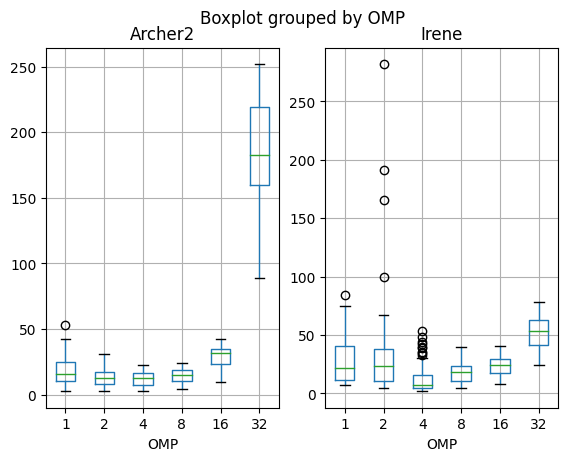

In [10]:
from matplotlib import pyplot as plt
from pandas import concat
dfl=read_csv('linear_benchs.csv',index_col=0)
fig,axs=plt.subplots(1,2)
ax=axs[0]
key='archer2_bench'
dfa=benchmark.df_select(dfl,{0:'archer'})
dfa.boxplot(by='OMP',column='CPUmin/at',ax=ax)
ax.set_title('Archer2')
ax=axs[1]
dfi=benchmark.df_select(dfl,{'Hostname':'irene'})
dfi.boxplot(by='OMP',column='CPUmin/at',ax=ax)
ax.set_title('Irene')

Interestingly, this does not happen on the `irene` platform, and for the other runs, the distribution
of the number of CPU minutes per atom seems similar, showing the overall linear scaling behaviour of the code.
We can highlight the irene plot to understand which are the outliers of the boxplots:

In [11]:
xcol='OMP'
ycol='CPUmin/at'
p = figure(title='Irene', 
           tools = [hover],
           toolbar_location = "below",
           x_axis_label=xcol, 
           y_axis_label=ycol)
# for idf,(name,df) in enumerate(dfs.items()):
#     if 'irene' not in name: continue
for idf,(iomp,dft) in enumerate(dfi.groupby('OMP')):
        i=omp[iomp]
        p.aspect_ratio = 2.
        p.scatter(i, ycol, size=5,color=colors[i],
                  legend_label=str(iomp),marker=markers[idf],
                  source=ColumnDataSource(dft))
show(p)

We then choose, for each of the platforms, the value which has the lower walltime with respect to a given number of nodes.

In [12]:
from benchmark import minimum_dataframe

/work/execute/bigdft-remote-bench/2CzPN/../benchmark.py:319: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group,dft in df.groupby(groups):


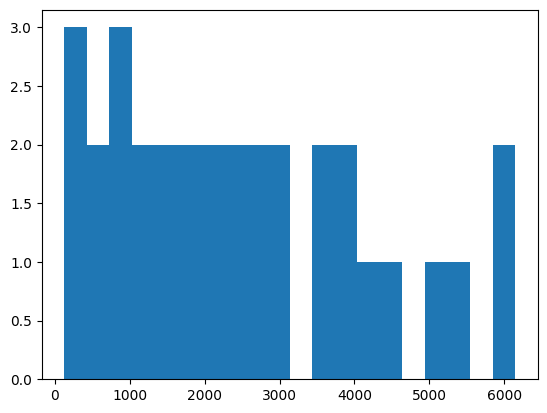

In [17]:
dfm=minimum_dataframe(dfl,128,groups=['Nodes'],walltime_key='WFN_OPT')
dft=benchmark.df_select(dfm,{'Hostname':'irene'})
limit=2
vals,cores,_=plt.hist(dft.cores,bins=20)
cores=[0]+[c for l,c in zip(vals,cores) if l >= limit]
#plt.hist(dfmc.cores)

In [18]:
from numpy import polyfit,linspace,array
from sklearn.linear_model import LinearRegression
data={}
dfd=[]
#cores=[0,1631,2534]
for ic in range(1,len(cores)):
    dftt=dft[(dft.cores > cores[ic-1]) & (dft.cores <= cores[ic]) & (dft.OMP < 16)]
    dftt=dftt[(~dftt['WFN_OPT'].isna()) & (abs(dftt['WFN_OPT']) < 10000)]
    #print(dftt[['Nat','WFN_OPT']])
    lb=int(cores[ic])
    x=array(dftt.Nat)
    y=array(dftt['WFN_OPT'])
    data[lb]={'x':x, 'y':y}
    reg = LinearRegression(fit_intercept=False).fit(x.reshape(-1,1), y.reshape(-1,1))
    #b, a = polyfit(x, y, deg=1)
    # Create sequence of 100 numbers from 0 to 100
    xseq = linspace(0, 5000, num=100)
    # Plot regression line
    if int(cores[ic])>= 1632:
        dfd.append(dftt)
        plt.plot(xseq, reg.coef_[0] * xseq, color="k", lw=2.5)
    plt.scatter(x,y,label=int(cores[ic]))
plt.legend()

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [122]:
x=array(list(data[1632]['x'])+list(data[2534]['x']))
y=array(list(data[1632]['y'])+list(data[2534]['y']))

In [19]:
dfttt=benchmark.minimum_dataframe(concat(dfd).sort_values('Nat'),128,groups=['Nat'])

ValueError: No objects to concatenate

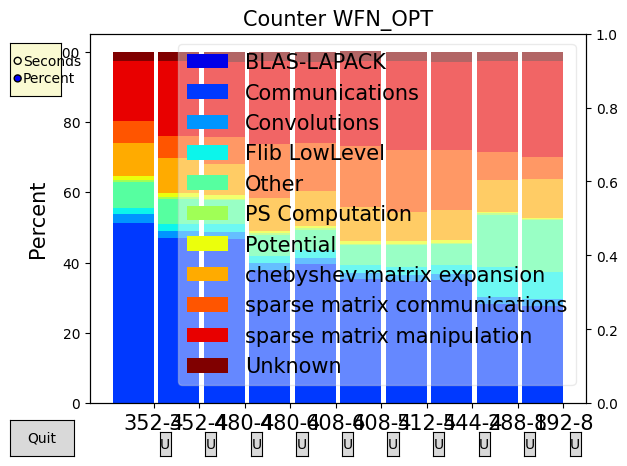

In [152]:
from futile import Time as T
tt=T.TimeData(*dfttt.timefile,plottype='Percent',strong_scaling=False)

In [153]:
array(dfttt.Nat)

array([756, 864, 1188, 1404, 1620, 1836, 2052, 2268, 2700, 3996],
      dtype=object)

In [154]:
len(tt.ids),len(array(dfttt.Nat))

(10, 10)

In [155]:
benchmark.draw_barplot(tt.ids,tt.actual_data,x=array(dfttt.Nat))

<Axes: >

Error in callback <function _draw_all_if_interactive at 0x14e4234de550> (for post_execute), with arguments args (),kwargs {}:


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 640x480 with 1 Axes>

In [134]:
dfttt

name  \
local_work_irene_gnu_linear/log-2CzPN_14.pdb-35...  2CzPN_14.pdb-352-4   
local_work_irene_gnu_linear/log-2CzPN_16.pdb-35...  2CzPN_16.pdb-352-4   
local_work_irene_gnu_linear/log-2CzPN_22.pdb-35...  2CzPN_22.pdb-352-4   
local_work_irene_gnu_linear/log-2CzPN_22.pdb-48...  2CzPN_22.pdb-480-4   
local_work_irene_gnu_linear/log-2CzPN_26.pdb-35...  2CzPN_26.pdb-352-4   
local_work_irene_gnu_linear/log-2CzPN_26.pdb-48...  2CzPN_26.pdb-480-4   
local_work_irene_gnu_linear/log-2CzPN_30.pdb-44...  2CzPN_30.pdb-448-4   
local_work_irene_gnu_linear/log-2CzPN_30.pdb-60...  2CzPN_30.pdb-608-4   
local_work_irene_gnu_linear/log-2CzPN_34.pdb-44...  2CzPN_34.pdb-448-4   
local_work_irene_gnu_linear/log-2CzPN_34.pdb-60...  2CzPN_34.pdb-608-4   
local_work_irene_gnu_linear/log-2CzPN_38.pdb-51...  2CzPN_38.pdb-512-4   
local_work_irene_gnu_linear/log-2CzPN_42.pdb-35...  2CzPN_42.pdb-352-4   
local_work_irene_1.9.4_gnu_linear/log-2CzPN_42....  2CzPN_42.pdb-224-8   
local_work_irene_gnu_linear/log-2CzPN_42.pdb-54...  2CzPN_42.pdb-544-4   
local_work_irene_1.9.4_gnu_linear/log-2CzPN_50....  2CzPN_50.pdb-288-8   
local_work_irene_1.9.4_gnu_linear/log-2CzPN_74....  2CzPN_74.pdb-192-8   

                                                                                             timefile  \
local_work_irene_gnu_linear/log-2CzPN_14.pdb-35...  local_work_irene_gnu_linear/./time-2CzPN_14.pd...   
local_work_irene_gnu_linear/log-2CzPN_16.pdb-35...  local_work_irene_gnu_linear/./time-2CzPN_16.pd...   
local_work_irene_gnu_linear/log-2CzPN_22.pdb-35...  local_work_irene_gnu_linear/./time-2CzPN_22.pd...   
local_work_irene_gnu_linear/log-2CzPN_22.pdb-48...  local_work_irene_gnu_linear/./time-2CzPN_22.pd...   
local_work_irene_gnu_linear/log-2CzPN_26.pdb-35...  local_work_irene_gnu_linear/./time-2CzPN_26.pd...   
local_work_irene_gnu_linear/log-2CzPN_26.pdb-48...  local_work_irene_gnu_linear/./time-2CzPN_26.pd...   
local_work_irene_gnu_linear/log-2CzPN_30.pdb-44...  local_work_irene_gnu_linear/./time-2CzPN_30.pd...   
local_work_irene_gnu_linear/log-2CzPN_30.pdb-60...  local_work_irene_gnu_linear/./time-2CzPN_30.pd...   
local_work_irene_gnu_linear/log-2CzPN_34.pdb-44...  local_work_irene_gnu_linear/./time-2CzPN_34.pd...   
local_work_irene_gnu_linear/log-2CzPN_34.pdb-60...  local_work_irene_gnu_linear/./time-2CzPN_34.pd...   
local_work_irene_gnu_linear/log-2CzPN_38.pdb-51...  local_work_irene_gnu_linear/./time-2CzPN_38.pd...   
local_work_irene_gnu_linear/log-2CzPN_42.pdb-35...  local_work_irene_gnu_linear/./time-2CzPN_42.pd...   
local_work_irene_1.9.4_gnu_linear/log-2CzPN_42....  local_work_irene_1.9.4_gnu_linear/./time-2CzPN...   
local_work_irene_gnu_linear/log-2CzPN_42.pdb-54...  local_work_irene_gnu_linear/./time-2CzPN_42.pd...   
local_work_irene_1.9.4_gnu_linear/log-2CzPN_50....  local_work_irene_1.9.4_gnu_linear/./time-2CzPN...   
local_work_irene_1.9.4_gnu_linear/log-2CzPN_74....  local_work_irene_1.9.4_gnu_linear/./time-2CzPN...   

                                                   WFN_OPT        energy  \
local_work_irene_gnu_linear/log-2CzPN_14.pdb-35...   424.0  -3681.362268   
local_work_irene_gnu_linear/log-2CzPN_16.pdb-35...   636.0  -4207.249554   
local_work_irene_gnu_linear/log-2CzPN_22.pdb-35...   701.0  -5785.028341   
local_work_irene_gnu_linear/log-2CzPN_22.pdb-48...   587.0  -5785.028341   
local_work_irene_gnu_linear/log-2CzPN_26.pdb-35...   936.0   -6836.85817   
local_work_irene_gnu_linear/log-2CzPN_26.pdb-48...   802.0   -6836.85817   
local_work_irene_gnu_linear/log-2CzPN_30.pdb-44...   953.0  -7888.664016   
local_work_irene_gnu_linear/log-2CzPN_30.pdb-60...   791.0  -7888.664016   
local_work_irene_gnu_linear/log-2CzPN_34.pdb-44...  1130.0  -8940.506097   
local_work_irene_gnu_linear/log-2CzPN_34.pdb-60...   941.0  -8940.506097   
local_work_irene_gnu_linear/log-2CzPN_38.pdb-51...  1230.0  -9992.346792   
local_work_irene_gnu_linear/log-2CzPN_42.pdb-35...  1540.0 -11044.141398   
local_work_irene_1.9.4_gnu_linear

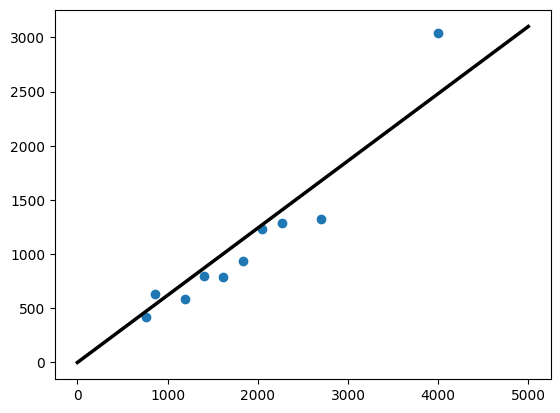

In [156]:
x=array(dfttt.Nat)
y=array(dfttt.WFN_OPT)
plt.scatter(x,y)
reg = LinearRegression(fit_intercept=False).fit(x.reshape(-1,1), y.reshape(-1,1))
plt.plot(xseq, reg.coef_[0] * xseq, color="k", lw=2.5)

/work/execute/bigdft-remote-bench/2CzPN/../benchmark.py:319: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group,dft in df.groupby(groups):
/work/execute/bigdft-remote-bench/2CzPN/../benchmark.py:319: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group,dft in df.groupby(groups):


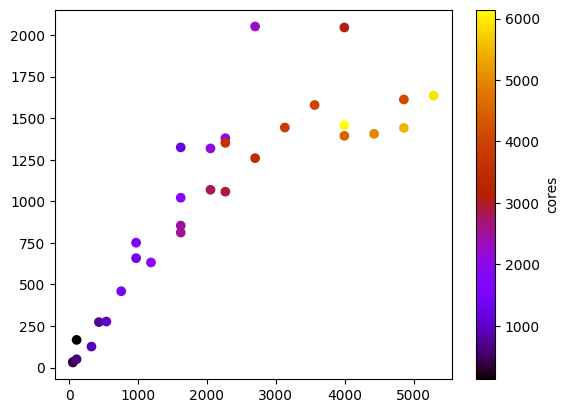

In [20]:
dfmc=minimum_dataframe(dfc,128,groups=['Nodes'],walltime_key='WFN_OPT')
dfm=minimum_dataframe(dfl,128,groups=['Nodes'],walltime_key='WFN_OPT')
from matplotlib import colormaps,pyplot as plt
cmap=colormaps.get_cmap('gnuplot')
plt.scatter(dfm.Nat,dfm.Walltime,c=dfm['cores'],cmap=cmap)
#plt.scatter(dfmc.Nat,dfmc.Walltime,c=dfmc['cores'],cmap=cmap,marker='s')
cb=plt.colorbar()
cb.set_label('cores')

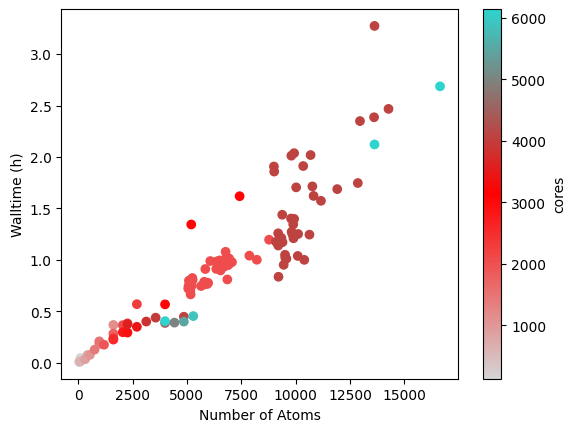

In [28]:
from matplotlib import ticker
plt.scatter(dftot.Nat,dftot.Walltime/3600,c=dftot['cores'],cmap=cmap1)
cb=plt.colorbar()
cb.set_label('cores')
plt.xlabel('Number of Atoms')
plt.ylabel('Walltime (h)')
plt.gca().get_yaxis().set_major_formatter(ticker.ScalarFormatter())
plt.gcf().savefig('LS.png')

<Axes: xlabel='CPUmin/at'>

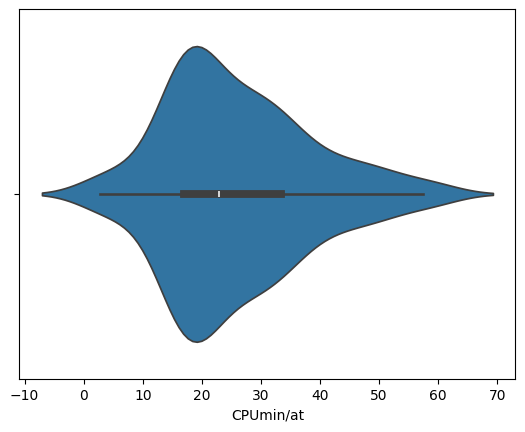

In [255]:
import seaborn as sns
sns.violinplot(data=dftot,x='CPUmin/at')

/opt/intel/oneapi/intelpython3/lib/python3.9/site-packages/matplotlib/cbook.py:1320: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/intel/oneapi/intelpython3/lib/python3.9/site-packages/matplotlib/cbook.py:1327: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/opt/intel/oneapi/intelpython3/lib/python3.9/site-packages/matplotlib/cbook.py:1335: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/opt/intel/oneapi/intelpython3/lib/python3.9/site-packages/matplotlib/cbook.py:1336: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


{'whiskers': [<matplotlib.lines.Line2D at 0x14e3fb583340>,
 'caps': [<matplotlib.lines.Line2D at 0x14e3fb583880>,
 'boxes': [<matplotlib.lines.Line2D at 0x14e3fb583070>],
 'medians': [<matplotlib.lines.Line2D at 0x14e3fb583dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x14e3fb58e0a0>],
 'means': []}

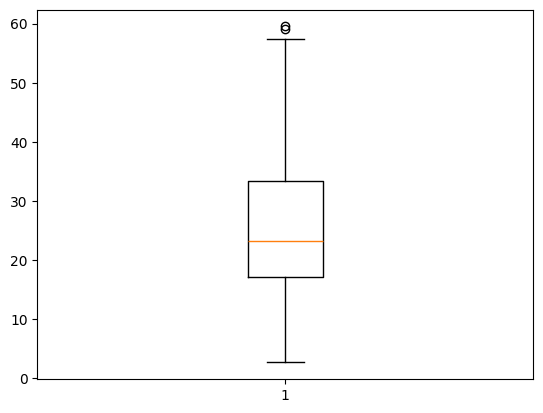

In [251]:
plt.boxplot(dftot['CPUmin/at'])

In [ ]:
cb.

In [22]:
dfp=read_csv('../../pdbbind-analysis/dimers.csv', index_col=0)

In [23]:
dfp=benchmark.minimum_dataframe(dfp,128,groups=['Nat'])

/work/execute/bigdft-remote-bench/2CzPN/../benchmark.py:319: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group,dft in df.groupby(groups):


In [24]:
dfp=dfp[((dfp['CPUmin/at'] < 20) | (dfp['cores'] > 3000) & (dfp['CPUmin/at'] < 60)) & (dfp['cores'] > 1500)]

In [25]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#D4D4D4', '#FF0000', '#2ED4CE'] #["darkorange", "gold", "lawngreen", "lightseagreen"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

<Axes: xlabel='Nat', ylabel='Walltime'>

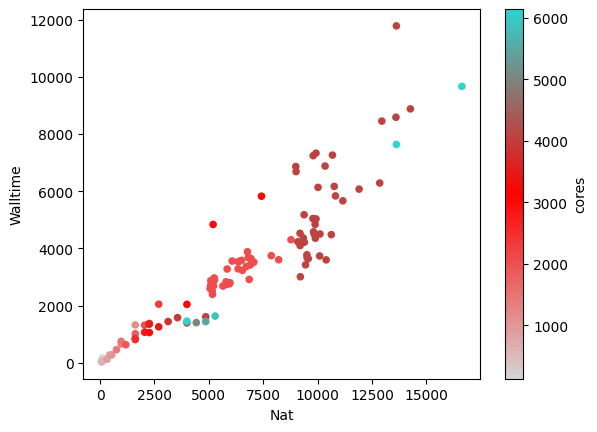

In [26]:
dftot=concat([dfp,dfm])
dftot.plot.scatter('Nat','Walltime',c='cores',cmap=cmap1)
# ax=dfp.plot.scatter('Nat','Walltime',c='cores',cmap='gnuplot')
# dfm.plot.scatter('Nat','Walltime',c='cores',cmap='gnuplot',ax=ax)

<Axes: xlabel='Nat', ylabel='CPUmin/at'>

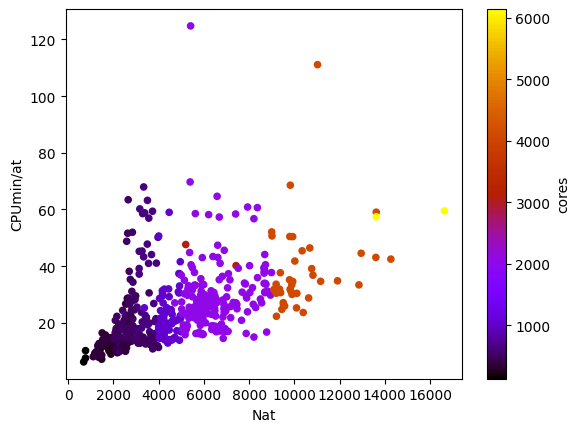

In [169]:
dfp.plot.scatter('Nat','CPUmin/at',c='cores',cmap='gnuplot')

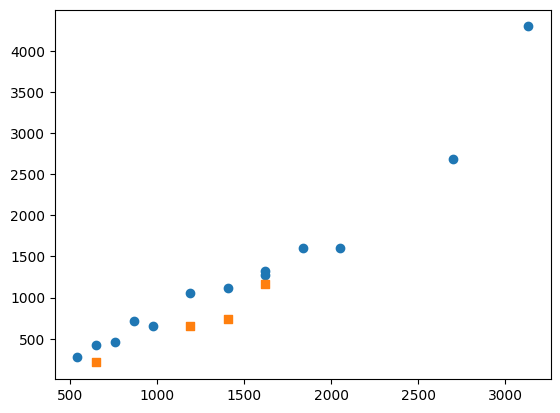

In [33]:
plt.scatter(dftt.Nat,dftt.Walltime)#c=dftt['cores'],cmap=cmap)
plt.scatter(dftc.Nat,dftc.Walltime,marker='s')#c=dftc['cores'],cmap=cmap,)
#plt.colorbar()

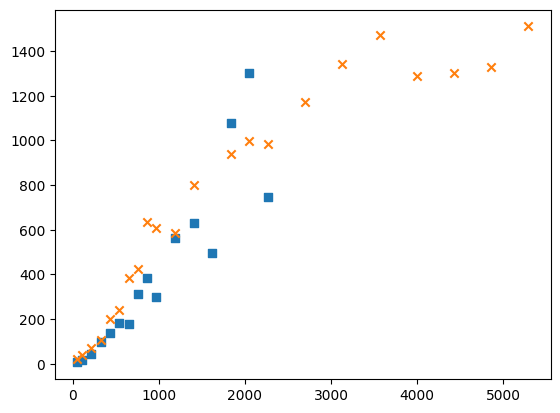

In [158]:
plt.scatter(x=dfmc.Nat,y=dfmc.WFN_OPT,marker='s')
plt.scatter(dfm.Nat,dfm.WFN_OPT,marker='x')

/tmp/ipykernel_65683/1163551897.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('gnuplot')


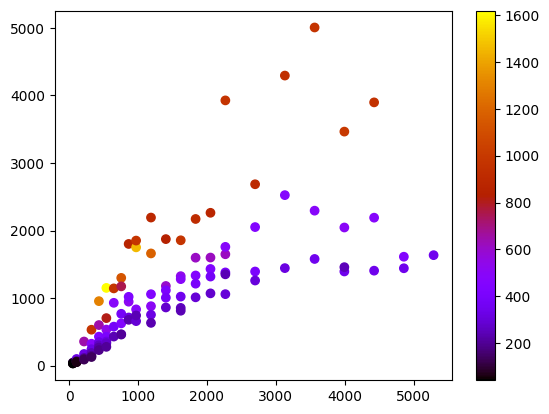

In [13]:
from matplotlib import cm,pyplot as plt
cmap=cm.get_cmap('gnuplot')
plt.scatter(dfm.Nat,dfm.Walltime,c=dfm['SF/Node'],cmap=cmap)
plt.colorbar()

<Axes: xlabel='SF/Node', ylabel='CPUmin/at'>

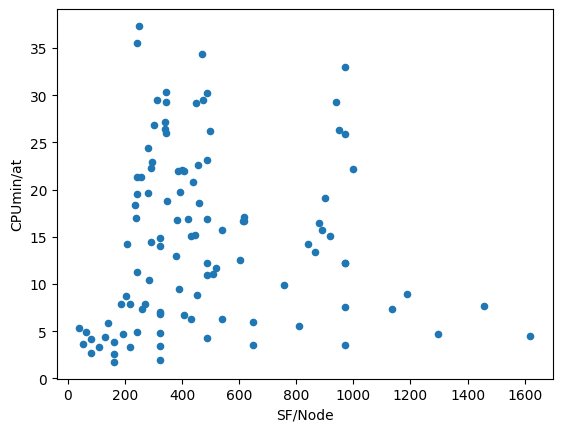

In [14]:
dfm.plot.scatter(y='CPUmin/at',x='SF/Node')

<Axes: xlabel='Nat', ylabel='Walltime'>

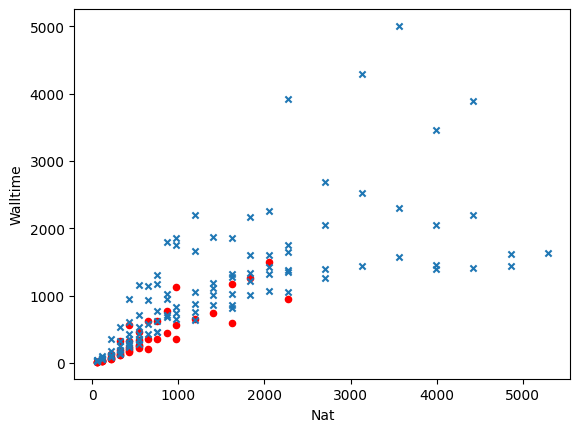

In [15]:
ax=dfmc.plot.scatter(y='Walltime',x='Nat',color='r')
dfm.plot.scatter(y='Walltime',x='Nat',ax=ax,marker='x')

In [267]:
dfmm=minimum_dataframe(dfi,128,groups='Nat')#,walltime_key='CPUmin/at')#[['Nat','WFN_OPT','Walltime','CPUmin/at']]
dfmcm=minimum_dataframe(df,128,groups='Nat')#,walltime_key='CPUmin/at')

In [19]:
dfmm=minimum_dataframe(dfi,128,groups='cores',walltime_key='CPUmin/at')#[['Nat','WFN_OPT','Walltime','CPUmin/at']]
dfmcm=minimum_dataframe(dfc,128,groups='cores',walltime_key='CPUmin/at')

In [114]:
def for_table(dfs,time,ideal,speedup,efficiency):
    from pandas import DataFrame
    return DataFrame({
        'Nat': dfs.Nat,
        'MPI':dfs.MPI,
        'OMP':dfs.OMP,
        'cores':dfs.cores,
        'time':time,
        'ideal time':ideal,
        'Speedup':speedup,
        'Eff.':efficiency})

def weak_scaling(ax,dfs,x='cores',y='Walltime',marker='o-'):
    from numpy import argmin
    c=dfs[x]
    t=dfs[y]
    im=0#argmin(t)
    ideal_su=c/c[im]
    ideal=t[im]
    eff=ideal/t
    #print(len(eff),eff[-1],max(eff),min(eff))
    if len(eff) <=1:
        return
    ax.semilogx(c,t,marker)
    ax.axhline(ideal,c='k',lw=1)
    return for_table(dfs,t,ideal,1,eff)
def strong_scaling(ax,dfs,x='cores',y='Walltime',marker='o-',**kwargs):
    from numpy import argmax
    c=dfs[x]
    t=dfs[y]
    im=argmax(t)
    ideal_su=c/c[im]
    ideal=t[im]*(c[im]/c)
    su=t[im]/t
    eff=ideal/t
    #print(len(eff),eff[-1],max(eff),min(eff))
    if min(eff) < 0.65 or max(eff) > 1.1:
       return
    ax.loglog(c,t,marker,**kwargs)
    ax.loglog(c,ideal,c='k')
    return for_table(dfs,t,ideal,su,eff)

/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Walltime')

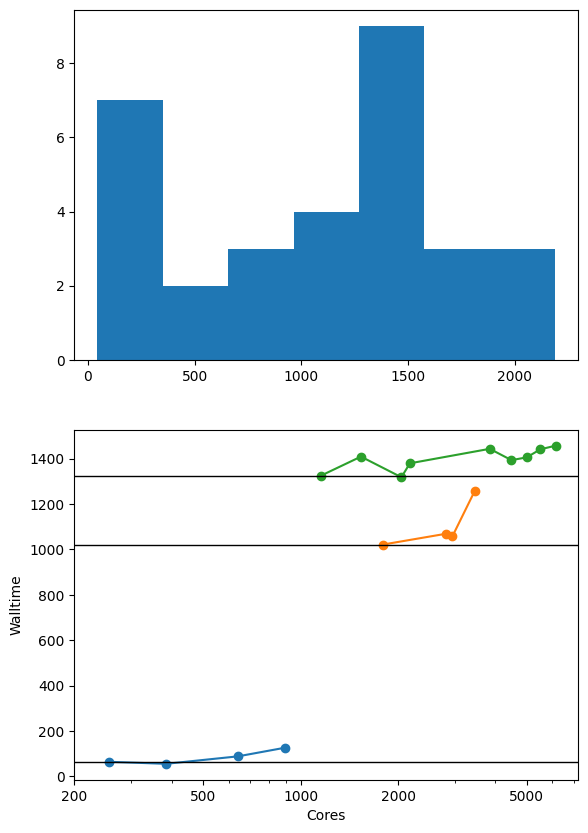

In [116]:
from pandas import cut
from numpy import arange
from matplotlib import ticker
fig,axs=plt.subplots(2,1,figsize=(6.5,10))
ax=axs[1]
col='Walltime'
dt=dfmm[col]
hist=axs[0].hist(dt,bins=7)
togroup=cut(dt, hist[1])
dfts=[]
for name,dft in dfmm.groupby(togroup):
    #print(name)
    dft=dft[dft.Nat != 540] #wrong runs
    if len(dft) <= 3:
        continue
    dfts.append(weak_scaling(ax,dft,y=col))
ax.set_xticks([200,500,1000,2000,5000])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Cores')
ax.set_ylabel(col)
# ax=axs[1][0]
# dt=dfmcm[col]
# hist=axs[1][1].hist(dt,bins=[0,50,200,500,1000,1500])
# for name,dft in dfmcm.groupby(cut(dt, hist[1])):
#     print(name)
#     if len(dft) <= 3:
#         continue
#     weak_scaling(ax,dft)
# ax.set_xticks([200,500,1000,2000,5000])
# ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

In [117]:
for name,dft in concat(dfts).groupby(togroup):
    if len(dft) <= 3:
        continue
    display(dft[['cores','Nat','time','Eff.']].sort_values('cores').style.format(precision=2).hide())

<Axes: xlabel='cores', ylabel='Walltime'>

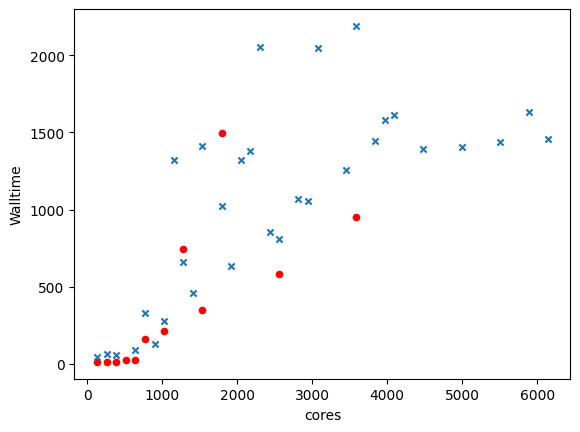

In [118]:
ax=dfmcm.plot.scatter(y='Walltime',x='cores',color='r')
dfmm.plot.scatter(y='Walltime',x='cores',ax=ax,marker='x')

<Axes: xlabel='Nat', ylabel='CPUmin/at'>

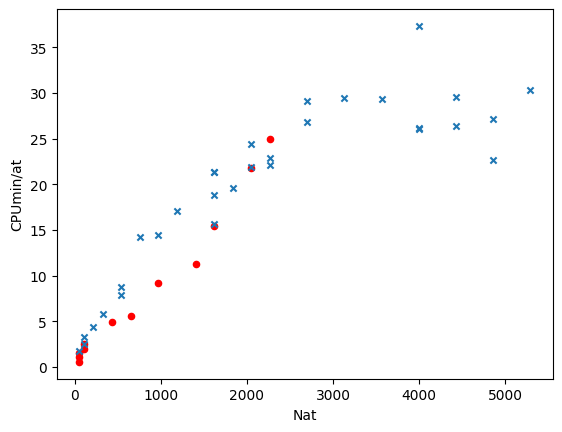

In [119]:
ykey='CPUmin/at'
ax=dfmcm.plot.scatter(y=ykey,x='Nat',color='r')
dfmm.plot.scatter(y=ykey,x='Nat',ax=ax,marker='x')

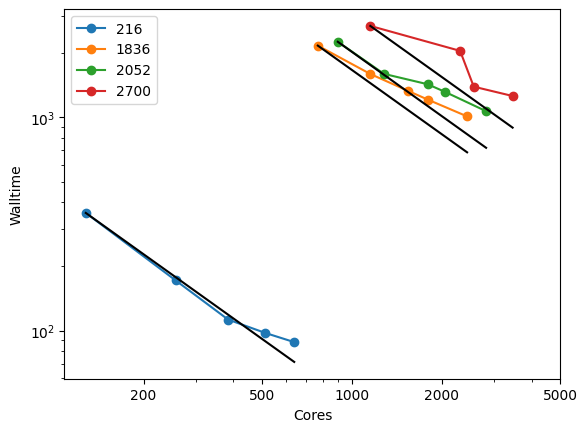

In [123]:
dfts=[]
fig,ax=plt.subplots()
for nat in sorted(set(dfm.Nat)):
    dfs=dfm[dfm.Nat==nat].dropna()
    if len(dfs) <= 3:
        continue
    #print(nat)
    dfts.append(strong_scaling(ax,dfs,y='Walltime',label=nat))
# for nat in allnat:
#     dfs=dfmc[dfmc.Nat==nat]
#     if len(dfs) <= 2: continue
#     dfts.append(strong_scaling(ax,dfs,marker='x-'))
ax.set_xticks([200,500,1000,2000,5000])
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Cores')
ax.set_ylabel('Walltime')
_=ax.legend(loc='best')

In [125]:
from IPython.display import display
for name,dft in concat(dfts).groupby('Nat'):
    display(dft[['Nat','cores','time','Eff.']].style.format(precision=2).hide())